# Классификация дорожных знаков

### В этом ноутбуке будем классифицировать дорожные знаки Швеции. 
Вики: https://commons.wikimedia.org/wiki/Road_signs_in_Sweden
### Рассмотрим:
    - как загружать реальные данные в pytorch
    - с какими проблемами можно столкнуться при работе с реальными данными
    - способы проверки работоспособности сети(validation)

In [1]:
# Установим размер классифицируемых изображений
PIC_SIZE = 50
# Путь к предобработанным данным
data_path = 'data//preprocessed//'
# Путь, куда сохраним модель
model_save_path = 'signs_classifier.pth'

In [2]:
import pandas as pd
import numpy as np
import torch
import os
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

### Создадим класс-обёртку для нашего датасета

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class SignsDataset(Dataset):
    """Road signs dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.signs_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Cоздаём массив label->index и массив index->label
        self.labels = self.signs_frame['label'].unique()
        self.label_indexes = {}
        for i, label in enumerate(self.labels):
            self.label_indexes[label] = i

    def __len__(self):
        return len(self.signs_frame)

    def __getitem__(self, idx):
        # Загрузим изображение и приведём к размеру 50х50
        # Названия файлов лежат в self.sings_frame
        # На выходе ожидается ровно одно изображение
        
        img_name = self.root_dir + self.signs_frame.iloc[idx, 0]
        image = Image.open(img_name)
        image = image.resize((PIC_SIZE, PIC_SIZE), Image.ANTIALIAS)
        
        ###############################################################################
        
        # В роли ответа будем давать номер label
        # массив label->index создан в конструкторе
        label_string = self.signs_frame.iloc[idx, 1]
        label = self.label_indexes[label_string]
        
        # Применим преобразования изображения (например аугментацию)
        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}
        return sample

### Создадим DataLoader'ы, облегчающие закрузку и сэмплинг данных

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Инициализируем загрузчик датасета (класс выше)
dataset = SignsDataset(data_path + 'labels.csv', 
                       data_path, 
                       torchvision.transforms.ToTensor())

indicies = np.arange(len(dataset))

# Некоторые кадры идут подряд и почти совпадают
# Нужно ли включать shuffle? Сделайте ваш выбор :)
####### ОТВЕТ: Объективность оценки качества сети упадёт, т.к. кадры из train просочаться в validation
####### ОТВЕТ: Нет не нужно.
#np.random.seed(0)
#np.random.shuffle(indicies)

# Разбиение датасета на train и validation
train_sampler = SubsetRandomSampler(indicies[:int(len(dataset)*0.5)])
validation_sampler = SubsetRandomSampler(indicies[int(len(dataset)*0.5):])

# DataLoader достаёт данные из dataset батчами
signsTrainLoader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
signsValidationLoader = DataLoader(dataset, batch_size=32, sampler=validation_sampler)

### Взглянем на данные

tensor(8) PEDESTRIAN_CROSSING


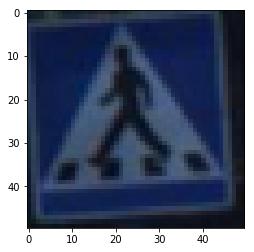

In [7]:
# Преобразование из torch.Tensor к PIL Image(это функция)
ToPIL = transforms.ToPILImage()

# Посмотрим, что выдаёт одна итерация DataLoader
# DataLoader является генератором, получите один элемент и выведите на экран

batch = next(iter(signsTrainLoader))

print(batch['label'][0], dataset.labels[batch['label'][0]])
plt.imshow(ToPIL(batch['image'][0]))

### Данные сильно несбалансированы (unbalanced dataset)
### Задача
    Взгляните на количество представителей каждого класса 
    К чему это может привести?
#### мало 120_SIGN, PASS_LEFT_SIDE, STOP, скорее всего на них не обучится 
#### датасет сильно несбалансирован, в итоге, например 120_SIGN будет распознаваться как 100_SIGN
    
    Подумайте о вариантах исправления проблемы
#### upsampling, аугментация данных, transfer learning (но с 6 и 9 примерами ничего не поможет)
#### С 6 примерами легче исключить класс в принципе

In [8]:
df = dataset.signs_frame
classes_number = df['label'].nunique()
print('Classes number:', classes_number)
df.groupby('label')['file_name'].nunique()

Classes number: 19


label
100_SIGN                   112
110_SIGN                    28
120_SIGN                     9
30_SIGN                     40
50_SIGN                    168
60_SIGN                     29
70_SIGN                    200
80_SIGN                    111
90_SIGN                     26
GIVE_WAY                   193
NO_PARKING                  95
NO_STOPPING_NO_STANDING    101
OTHER                      372
PASS_EITHER_SIDE            29
PASS_LEFT_SIDE               6
PASS_RIGHT_SIDE            414
PEDESTRIAN_CROSSING        680
PRIORITY_ROAD              488
STOP                        27
Name: file_name, dtype: int64

## Создаём и обучаем сеть

In [9]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>

### Реализуйте сеть примерно следующей архитектуры:
    conv -> max_pool -> conv -> fc -> fc -> fc

In [10]:
# Класс свёрточной нейронной сети
class SimpleConvNet(nn.Module):
    def __init__(self, class_number):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 3),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.fc1 = nn.Linear(16 * 9 * 9, 120)  # !!! 
        
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, class_number)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Подаём картинку на вход и увидим, сколько элементов на входе первого fully connected!
        # Подробнее замечание снизу (оно из прошлого семинара)
        # print(x.shape)
        ## ИЛИ ЖЕ МОЖНО ЭТО РАССЧИТАТЬ, НО ЭТО ДОЛЬШЕ
        
        x = x.view(-1, 16 * 9 * 9)  # !!! Аналог Flatten в keras
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Функция акктивации отсутствует
        # torch.nn.CrossEntropyLoss разбирается с этим сам
        return x

#### Примечание из прошлого семинара
Важное примечание: Вы можете заметить, что в строчках с #!!! есть не очень понятный сходу  9∗9∗16 . Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, .Flatten() всё делает за Вас). Однако есть один лайфхак -- просто сделайте в forward() print(x.shape) (закомментированная строка). Вы увидите размер (batch_size, C, H, W) -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность Linear(), и именно в C H W нужно "развернуть" x перед подачей в Linear().

То есть нужно будет запустить цикл с обучением первый раз с print() и сделать после него break, посчитать размер, вписать его в нужные места и стереть print() и break.

In [11]:
# Создаём сеть
cnn = SimpleConvNet(classes_number)

In [12]:
# Взглянем на вывод
batch = next(iter(signsTrainLoader))
cnn(batch['image'])[0]

tensor([ 0.0862,  0.0368, -0.0704, -0.1106, -0.0246, -0.0020,  0.0054, -0.1120,
        -0.0222, -0.1026,  0.0026, -0.0338, -0.0289,  0.0301, -0.1052, -0.0697,
        -0.0667, -0.0617, -0.0634], grad_fn=<SelectBackward>)

In [13]:
from tqdm import tqdm_notebook

# С помощью этого увидим, как сеть обучалась
history = {'loss':[], 'val_loss':[]}

# Выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# Выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Цикл обучения
i = 0
for epoch in tqdm_notebook(range(100)):

    running_loss = 0.0
    for batch in signsTrainLoader:
        # Так получаем текущий батч
        X_batch, y_batch = batch['image'], batch['label']
        
        # Обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = cnn(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        
        ###### Дальнейший код нужен для логирования #####
        # Выведем текущий loss
        running_loss += loss.item()
        
        # Пишем в лог каждые 50 батчей
        if i % 50 == 49:
            batch = next(iter(signsValidationLoader))
            X_batch, y_batch = batch['image'], batch['label']
            y_pred = cnn(X_batch)
            
            history['loss'].append(loss.item())
            history['val_loss'].append(loss_fn(y_pred, y_batch).item())
        
        # Выведем качество каждые 1000 батчей
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0
        i += 1

# Сохраним модель
torch.save(cnn.state_dict(), model_save_path)
print('Обучение закончено')

[11,  1000] loss: 0.019
[21,  2000] loss: 0.026
[31,  3000] loss: 0.028
[41,  4000] loss: 0.030
[52,  5000] loss: 0.000
[62,  6000] loss: 0.005
[72,  7000] loss: 0.009
[82,  8000] loss: 0.010
[92,  9000] loss: 0.011

Обучение закончено


#### Загрузка обученной модели (для семинара)

In [14]:
cnn = SimpleConvNet(classes_number)
cnn.load_state_dict(torch.load(model_save_path))

### Начертим кривые обучения

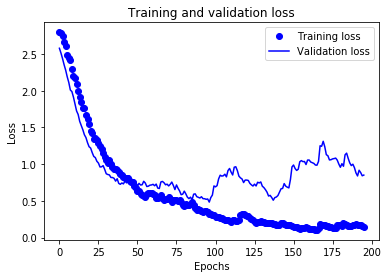

In [15]:
# Скользящее среднее
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.clf()
loss_values = smooth_curve(history['loss'])
val_loss_values = smooth_curve(history['val_loss'])
epochs = np.arange(len(loss_values))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Задача
    Оцените, насколько сеть переобучилась
    Что изменится, если применить 
        - регуляризацию?
##### Видимо задача не такая сложная, чтобы произошёл очень сильный оверфиттинг,
##### Однако сеть переобучилась, и при применении регуляризации линия из точек поползёт вверх, а ломанная вниз

#### Должно получиться так

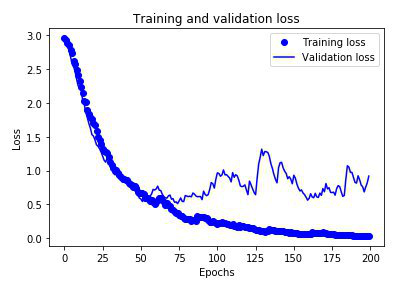

In [16]:
Image.open('curves.png')

### Выведем confusion matrix

In [17]:
import itertools
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

E:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Normalized confusion matrix


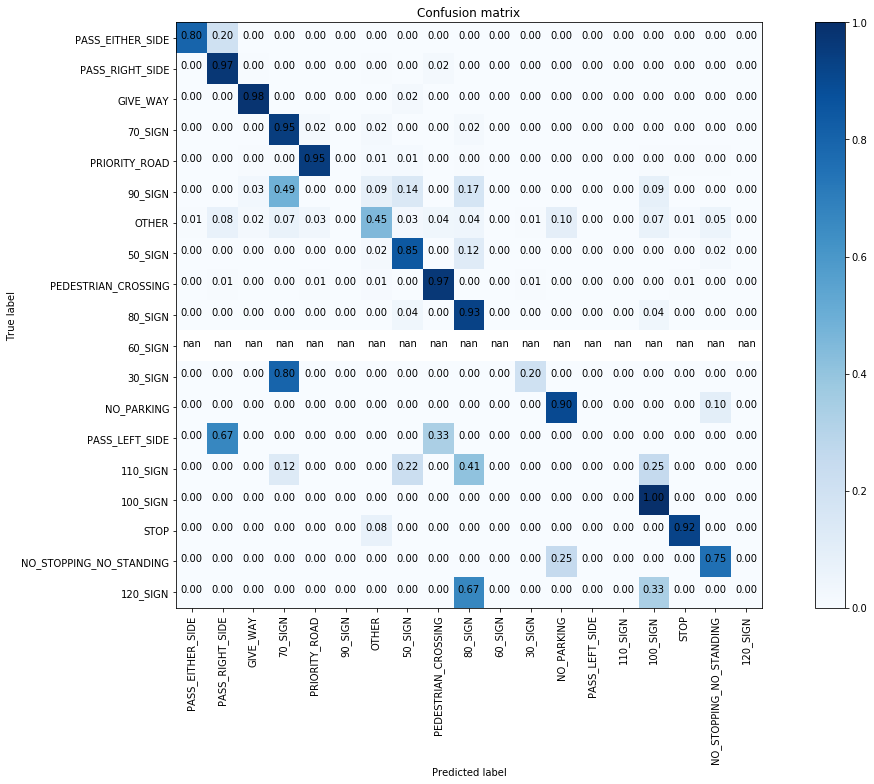

In [18]:
from sklearn.metrics import confusion_matrix

y_test_all = torch.Tensor().long()
predictions_all = torch.Tensor().long()

# Пройдём по всему validation датасету и запишем ответы сети
## Добавьте в y_test_all и predictions_all все истинные ответы и предсказания сети на Validation set'e,
## чтобы на основе этих данных оценить точность сети (в вашем распоряжении signsValidationLoader)

with torch.no_grad():
    for batch in signsValidationLoader:
        predictions = cnn(batch['image'])
        y_test = batch['label']
        _, predictions = torch.max(predictions, 1)
        
        # Аналог append для list
        y_test_all = torch.cat((y_test_all, y_test), 0)
        predictions_all = torch.cat((predictions_all, predictions), 0)

## Функция torch.cat - аналог append для обычного списка в питоне
## tensor = torch.cat((tensor, other_tensor), 0)       

feature_names = signsTrainLoader.dataset.labels

y_test_all = y_test_all.numpy()
predictions_all = predictions_all.numpy()

# Функция из sklearn, создаёт confusion матрицу
cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
# Выведем её
plot_confusion_matrix(cm, dataset.labels, normalize=True)

### Задача
    - какие выводы можно сделать из confusion matrix?
    - как связаны результаты с распределением данных в датасете?
#### Сеть плохо распознаёт числа на знаках, и совсем не распознаёт классы с небольшим количеством примеров

### Выведем точность для каждого класса

In [19]:
class_correct = [0 for i in range(classes_number)]
class_total = [0 for i in range(classes_number)]

c = (predictions_all == y_test_all).squeeze()
for i in range(len(predictions_all)):
    label = predictions_all[i]            
    class_correct[label] += c[i].item()
    class_total[label] += 1

print(class_total)

for i in range(classes_number):
    print('Accuracy of %5s : %2d %%' % (
        (dataset.labels[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

[5, 252, 57, 58, 254, 35, 157, 59, 485, 28, 0, 5, 51, 3, 32, 29, 13, 32, 9]
Accuracy of PASS_EITHER_SIDE : 80 %
Accuracy of PASS_RIGHT_SIDE : 97 %
Accuracy of GIVE_WAY : 98 %
Accuracy of 70_SIGN : 94 %
Accuracy of PRIORITY_ROAD : 95 %
Accuracy of 90_SIGN :  0 %
Accuracy of OTHER : 45 %
Accuracy of 50_SIGN : 84 %
Accuracy of PEDESTRIAN_CROSSING : 96 %
Accuracy of 80_SIGN : 92 %
Accuracy of 60_SIGN : -1 %
Accuracy of 30_SIGN : 20 %
Accuracy of NO_PARKING : 90 %
Accuracy of PASS_LEFT_SIDE :  0 %
Accuracy of 110_SIGN :  0 %
Accuracy of 100_SIGN : 100 %
Accuracy of  STOP : 92 %
Accuracy of NO_STOPPING_NO_STANDING : 75 %
Accuracy of 120_SIGN :  0 %


### Задача
    - какая связь между confusion matrix и accuracy для каждого класса?
#### Числа на диагонали confusion matrix и есть эти accuracy

### Оценим качество на отдельных кадрах из validation'а

Gound-true: PRIORITY_ROAD
Prediction: PRIORITY_ROAD


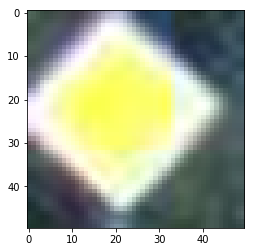

In [24]:
batch = next(iter(signsValidationLoader))
predictions = cnn(batch['image'])
y_test = batch['label']


#print(predictions, y_test)
_, predictions = torch.max(predictions, 1)
plt.imshow(ToPIL(batch['image'][0]))
print('Gound-true:', dataset.labels[batch['label'][0]])
print('Prediction:', dataset.labels[predictions[0]])

# Полезные ссылки

Лучшее руководство по matplotlib: https://matplotlib.org/faq/usage_faq.html